In [ ]:
!pip install optuna catboost

# 💰 Loan Approval Prediction 🏦

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
from IPython.display import display, HTML

warnings.filterwarnings('ignore')
import optuna

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.base import clone

from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


# Data Wrangling

### Gathering Data

In [ ]:
# !unzip playground-series-s4e10.zip
# !unzip archive.zip

Archive:  playground-series-s4e10.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
unzip:  cannot find or open archive.zip, archive.zip.zip or archive.zip.ZIP.


In [ ]:
train_df = pd.read_csv('train.csv', index_col='id')
test_df = pd.read_csv('test.csv', index_col='id')
orig_df = pd.read_csv('credit_risk_dataset.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/credit_risk_dataset.csv'

In [ ]:
orig_df.index

NameError: name 'orig_df' is not defined

In [ ]:
train_df = pd.concat([train_df, orig_df])
train_df = train_df.reset_index(drop=True)

In [ ]:
train_df.index

In [ ]:
train_df.head()

### Assessing Data

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [ ]:
train_df.duplicated().sum()


0

#### Removing Duplicate Data

In [ ]:

train_df.drop_duplicates(inplace=True)

#### Handling Missing Values

In [ ]:
train_df.isna().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,0
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,0
loan_percent_income,0
cb_person_default_on_file,0


In [ ]:
train_df['loan_int_rate'] = train_df['loan_int_rate'].fillna(train_df['loan_int_rate'].mean())
train_df['person_emp_length'] = train_df['person_emp_length'].fillna(train_df['person_emp_length'].mean())

In [ ]:
train_df.isna().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,0
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,0
loan_percent_income,0
cb_person_default_on_file,0


# Exploratory Data Analysis (EDA)

In [ ]:
target = 'loan_status'

In [ ]:
features = train_df.drop(target, axis=1).columns.tolist()

In [ ]:
categorical_features = train_df.select_dtypes(include='object').columns.tolist()

In [ ]:
numerical_features = list(set(features) - set(categorical_features))

In [ ]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,58645.0,27.550857,6.033216,20.00,23.00,26.00,30.00,123.00
person_income,58645.0,64046.172871,37931.106979,4200.00,42000.00,58000.00,75600.00,1900000.00
person_emp_length,58645.0,4.701015,3.959784,0.00,2.00,4.00,7.00,123.00
loan_amnt,58645.0,9217.556518,5563.807384,500.00,5000.00,8000.00,12000.00,35000.00
loan_int_rate,58645.0,10.677874,3.034697,5.42,7.88,10.75,12.99,23.22
loan_percent_income,58645.0,0.159238,0.091692,0.00,0.09,0.14,0.21,0.83
cb_person_cred_hist_length,58645.0,5.813556,4.029196,2.00,3.00,4.00,8.00,30.00
loan_status,58645.0,0.142382,0.349445,0.00,0.00,0.00,0.00,1.00




1. **Usia Pemohon (person_age)**:
   - Rata-rata usia pemohon adalah sekitar 27 tahun, dengan standar deviasi sekitar 6 tahun.
   - Rentang usia cukup lebar, mulai dari 20 hingga 144 tahun, yang mungkin menunjukkan data outlier di nilai maksimal (144 tahun) dan perlu ditinjau lebih lanjut.

2. **Pendapatan Pemohon (person_income)**:
   - Rata-rata pendapatan tahunan pemohon adalah sekitar $64,774, dengan standar deviasi yang cukup besar, yaitu sekitar $47,923. Hal ini menunjukkan variasi yang tinggi dalam pendapatan.
   - Pendapatan minimum $4,000 dan maksimum $6,000,000 juga menunjukkan adanya outlier di bagian atas, sehingga perlu diperiksa apakah ada data yang tidak realistis atau perlu transformasi.

3. **Lama Kerja (person_emp_length)**:
   - Rata-rata lama kerja adalah sekitar 4,7 tahun dengan standar deviasi 4 tahun.
   - Nilai minimum 0 mungkin menunjukkan pemohon yang baru mulai bekerja, sedangkan nilai maksimum 123 perlu diperiksa karena bisa jadi ini adalah data yang salah atau perlu diproses ulang.

4. **Jumlah Pinjaman (loan_amnt)**:
   - Rata-rata jumlah pinjaman yang diajukan adalah sekitar $9,351, dengan nilai minimum $500 dan maksimum $35,000.
   - Distribusi kuartil menunjukkan bahwa sebagian besar pemohon mengajukan pinjaman sekitar $5,000 hingga $12,000, jadi sebagian besar pinjaman berada di kisaran menengah.

5. **Suku Bunga (loan_int_rate)**:
   - Rata-rata suku bunga sekitar 10.79%, dengan standar deviasi 3%.
   - Nilai minimum suku bunga adalah 5.42%, dan maksimum 23.22%, yang menunjukkan variasi cukup besar yang mungkin terkait dengan penilaian risiko dari masing-masing pemohon.

6. **Persentase Pinjaman terhadap Pendapatan (loan_percent_income)**:
   - Rata-rata rasio pinjaman terhadap pendapatan sekitar 16%, dengan standar deviasi sekitar 9.7%.
   - Rasio ini menunjukkan beban pinjaman pemohon dalam hubungannya dengan pendapatan. Nilai yang lebih tinggi mungkin mengindikasikan risiko default yang lebih besar.

7. **Riwayat Kredit (cb_person_cred_hist_length)**:
   - Rata-rata lama riwayat kredit adalah sekitar 5,8 tahun, dengan minimum 2 tahun dan maksimum 30 tahun.
   - Riwayat kredit yang lebih panjang biasanya memberikan lebih banyak informasi tentang perilaku finansial pemohon, sehingga bisa memengaruhi tingkat risiko.

8. **Status Persetujuan Pinjaman (loan_status)**:
   - Variabel `loan_status` adalah variabel target, dengan nilai rata-rata 0.1695, yang menunjukkan bahwa hanya sekitar 17% dari data yang memiliki pinjaman yang disetujui (dengan asumsi `1` berarti disetujui dan `0` tidak disetujui).
   - Ini menunjukkan adanya ketidakseimbangan kelas dalam data, dan perlu dipertimbangkan dalam pemilihan model dan metrik evaluasi.



In [ ]:
train_df[categorical_features].describe(include='O').T

,count,unique,top,freq
person_home_ownership,58645,4,RENT,30594
loan_intent,58645,6,EDUCATION,12271
loan_grade,58645,7,A,20984
cb_person_default_on_file,58645,2,N,49943


Berikut analisis dari fitur kategorikal berdasarkan hasil `describe()`:

1. **Kepemilikan Rumah Pemohon (`person_home_ownership`)**:
   - **Jumlah kategori**: Ada 4 kategori unik dalam fitur ini, dengan kategori paling umum adalah "RENT" (menyewa), yang muncul sebanyak 46,972 kali.
   - **Insight**: Jumlah besar pemohon yang menyewa bisa mengindikasikan pemohon dengan stabilitas finansial yang lebih rendah dibandingkan pemohon yang memiliki rumah sendiri atau memiliki properti lain. Atribut ini bisa memberikan indikasi tentang risiko pemohon dalam konteks kelayakan kredit.

2. **Tujuan Pinjaman (`loan_intent`)**:
   - **Jumlah kategori**: Ada 6 tujuan pinjaman unik, dengan "EDUCATION" sebagai tujuan paling umum, muncul sebanyak 18,682 kali.
   - **Insight**: Tujuan pinjaman dapat mempengaruhi tingkat risiko. Misalnya, pinjaman untuk pendidikan mungkin memiliki pola pengembalian yang berbeda dibandingkan pinjaman pribadi atau medis. Pemisahan ini mungkin bisa membantu model mempelajari pola risiko berdasarkan tujuan pinjaman.

3. **Kelas Kredit (`loan_grade`)**:
   - **Jumlah kategori**: Ada 7 kategori atau kelas kredit yang berbeda, dengan "A" sebagai kelas kredit paling umum, muncul sebanyak 31,687 kali.
   - **Insight**: Kelas kredit biasanya merepresentasikan risiko atau kelayakan kredit pemohon. Kelas "A" yang sering muncul mungkin menunjukkan sebagian besar pemohon memiliki riwayat kredit yang baik. Namun, model perlu mampu mendeteksi pemohon dengan kelas lebih rendah (misalnya, "D" atau "E") yang mungkin lebih berisiko.

4. **Riwayat Default Kredit Sebelumnya (`cb_person_default_on_file`)**:
   - **Jumlah kategori**: Ada 2 kategori, yaitu "Y" (Yes, pernah default) dan "N" (No, tidak pernah default), dengan "N" muncul sebanyak 76,629 kali.
   - **Insight**: Mayoritas pemohon tidak memiliki riwayat default, yang menunjukkan sebagian besar data pemohon relatif stabil. Namun, pemohon yang memiliki riwayat default mungkin lebih berisiko dan dapat memengaruhi model dalam memprediksi kelayakan pinjaman.

### Rekomendasi Analisis Tambahan
1. **Encoding Kategori**: Semua fitur ini perlu di-encode (misalnya, one-hot encoding atau label encoding) agar dapat digunakan dalam pemodelan.
2. **Distribusi Kategori di Target**: Lakukan analisis distribusi fitur kategorikal ini terhadap variabel target (`loan_status`) untuk melihat apakah ada hubungan yang signifikan antara kategori tertentu dengan persetujuan pinjaman. Misalnya, apakah pemohon dengan `loan_grade` tertentu lebih sering disetujui atau ditolak.
3. **Pemeriksaan Ketidakseimbangan**: Cek apakah ada ketidakseimbangan kategori yang signifikan, seperti pada `cb_person_default_on_file`, dan pertimbangkan cara-cara untuk menangani ketidakseimbangan ini agar model tidak menjadi bias.


In [ ]:
for col in categorical_features:
    display(train_df.groupby(col)[['loan_amnt', 'loan_int_rate']].agg(['min', 'mean', 'max']))


loan_amnt                      loan_int_rate             \
                            min          mean    max           min       mean   
person_home_ownership                                                           
MORTGAGE                   1000   9963.269417  35000          5.42   9.958439   
OTHER                      1000  10028.651685  25000          5.79  11.561348   
OWN                        1000   8740.431804  35000          5.42  10.707307   
RENT                        500   8659.063117  35000          5.42  11.256036   

                              
                         max  
person_home_ownership         
MORTGAGE               21.74  
OTHER                  20.52  
OWN                    20.11  
RENT                   23.22

loan_amnt                      loan_int_rate             \
                        min          mean    max           min       mean   
loan_intent                                                                 
DEBTCONSOLIDATION      1000   9150.314793  35000          5.42  10.613230   
EDUCATION              1000   9051.681363  35000          5.42  10.681510   
HOMEIMPROVEMENT        1000  10224.007962  35000          5.42  10.881809   
MEDICAL                 700   8819.990397  35000          5.42  10.742830   
PERSONAL               1000   9239.801318  35000          5.42  10.607075   
VENTURE                 500   9262.830886  35000          5.42  10.604354   

                          
                     max  
loan_intent               
DEBTCONSOLIDATION  21.74  
EDUCATION          21.74  
HOMEIMPROVEMENT    22.11  
MEDICAL            21.36  
PERSONAL           22.06  
VENTURE            23.22

loan_amnt                      loan_int_rate                  
                 min          mean    max           min       mean    max
loan_grade                                                               
A                700   8447.103746  35000          5.42   7.335176  19.04
B               1000   9622.485637  35000          5.99  11.034733  17.56
C                500   9009.894889  35000          5.79  13.510343  16.29
D               1000  10521.468017  35000          6.00  15.404599  19.13
E               1000  12176.313181  35000          7.88  16.930961  23.06
F               1750  12833.892617  30000         15.01  18.610940  22.06
G               1500  12559.090909  30000         18.07  20.327576  23.22

loan_amnt                     loan_int_rate  \
                                min         mean    max           min   
cb_person_default_on_file                                               
N                               500  9170.477985  35000          5.42   
Y                              1000  9487.752241  35000          5.99   

                                             
                                mean    max  
cb_person_default_on_file                    
N                          10.042178  21.74  
Y                          14.326300  23.22

Berikut adalah analisis untuk tiap kategori berdasarkan hasil agregasi pada kolom kategorikal terhadap nilai minimum, rata-rata, dan maksimum `loan_amnt` serta `loan_int_rate`.

### 1. `person_home_ownership` (Kepemilikan Rumah)
   - **MORTGAGE** memiliki rata-rata jumlah pinjaman tertinggi (`mean loan_amnt` sekitar 10,179) dengan rata-rata suku bunga lebih rendah (`mean loan_int_rate` sekitar 10.15%).
   - **RENT** memiliki jumlah pinjaman rata-rata terendah (`mean loan_amnt` sekitar 8,731) dan rata-rata suku bunga tertinggi (11.3%).
   - **Insight**: Pemohon dengan status "MORTGAGE" cenderung mendapatkan pinjaman yang lebih besar dengan tingkat bunga lebih rendah, yang mungkin menunjukkan stabilitas finansial lebih tinggi, sehingga dianggap risiko lebih rendah. Sebaliknya, pemohon yang menyewa (RENT) mendapatkan pinjaman lebih rendah tetapi dengan suku bunga lebih tinggi, menunjukkan risiko yang lebih besar.

### 2. `loan_intent` (Tujuan Pinjaman)
   - Rata-rata jumlah pinjaman tertinggi ditemukan pada kategori **HOMEIMPROVEMENT** (`mean loan_amnt` sekitar 10,274), sedangkan **MEDICAL** memiliki rata-rata pinjaman terendah (`mean loan_amnt` sekitar 8,980).
   - Suku bunga rata-rata untuk semua kategori relatif mirip, tetapi **HOMEIMPROVEMENT** mencapai suku bunga maksimum tertinggi (23.22%), sementara **VENTURE** dan **DEBTCONSOLIDATION** juga cukup tinggi pada kisaran maksimum yang sama.
   - **Insight**: Tujuan pinjaman untuk **HOMEIMPROVEMENT** cenderung lebih besar dengan tingkat bunga yang lebih bervariasi, yang mungkin terkait dengan penggunaan jangka panjang dan perbaikan aset pribadi. Sementara itu, **VENTURE** dan **DEBTCONSOLIDATION** mungkin memiliki tingkat risiko yang lebih tinggi, mengakibatkan suku bunga maksimum yang tinggi.

### 3. `loan_grade` (Kelas Kredit)
   - Rata-rata jumlah pinjaman dan suku bunga meningkat dari kelas **A** ke **G**:
      - **Grade A** memiliki rata-rata pinjaman terendah (sekitar 8,480) dan suku bunga rata-rata terendah (7.44%).
      - **Grade G** memiliki rata-rata pinjaman tertinggi (sekitar 15,618) dan suku bunga rata-rata tertinggi (19.78%).
   - **Insight**: Kelas kredit yang lebih tinggi (misalnya, A atau B) cenderung dikaitkan dengan pinjaman lebih rendah dan tingkat bunga lebih rendah, yang menunjukkan pemohon berisiko rendah. Kelas yang lebih rendah (seperti E, F, G) lebih berisiko dan diberikan suku bunga tinggi. Informasi ini dapat membantu model dalam memahami hubungan antara kelas kredit dan risiko pinjaman.

### 4. `cb_person_default_on_file` (Riwayat Default)
   - Pemohon yang **tidak memiliki riwayat default** memiliki rata-rata pinjaman (`mean loan_amnt`) sebesar 9,277 dan rata-rata suku bunga 10.13%.
   - Pemohon **dengan riwayat default** memiliki rata-rata pinjaman lebih tinggi (`mean loan_amnt` sebesar 9,743) dan suku bunga lebih tinggi pula (14.26%).
   - **Insight**: Pemohon dengan riwayat default mendapatkan suku bunga lebih tinggi karena dianggap lebih berisiko, meskipun jumlah pinjamannya hampir sama dengan yang tidak memiliki riwayat default. Riwayat ini menjadi indikator penting dalam analisis risiko.

### Kesimpulan Umum
1. **Kepemilikan Rumah** dan **Tujuan Pinjaman** memberikan gambaran stabilitas keuangan dan motivasi peminjam.
2. **Kelas Kredit** dan **Riwayat Default** adalah indikator utama untuk memahami risiko pemohon, dengan implikasi langsung pada suku bunga dan jumlah pinjaman.
3. **Strategi Pemodelan**: Fitur-fitur ini dapat dimanfaatkan untuk melatih model dalam memprediksi risiko dan persetujuan pinjaman. Encoding variabel kategorikal ini juga penting agar model dapat mengenali pola risiko lebih akurat.

Data ini memberikan gambaran penting untuk memperkirakan risiko kredit berdasarkan profil dan karakteristik peminjam.

#### Feature Distribution¶

In [ ]:
def feature_distribution_plot(df, col, target_col=None):
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    if df[col].dtype != 'object':
        sns.histplot(data=df, x=col, hue=target_col)
    else:
        sns.countplot(data=df, x=col, hue=target_col)
    plt.ylabel('Count')
    plt.xlabel(f'{col}')
    plt.title(f'Histogram of {col}')

    plt.subplot(1,2,2)
    if df[col].dtype != 'object':
        sns.boxplot(data=df, x=col, hue=target_col)
        plt.title(f'Boxplot of {col}')
        plt.ylabel('Count')
        plt.xlabel(f'{col}')
    else:
        df[col].value_counts().plot(kind='pie', autopct='%.0f%%',pctdistance=0.85,fontsize=12)
        plt.gca().add_artist(plt.Circle((0,0),radius=0.7,fc='white'))
        plt.title(f'Pie Chart of {col}')
        plt.xlabel('')
        plt.ylabel('')


    plt.tight_layout()
    plt.suptitle(f'Distribution of {col}', y=1.05, size=24, weight='bold')
    plt.show()

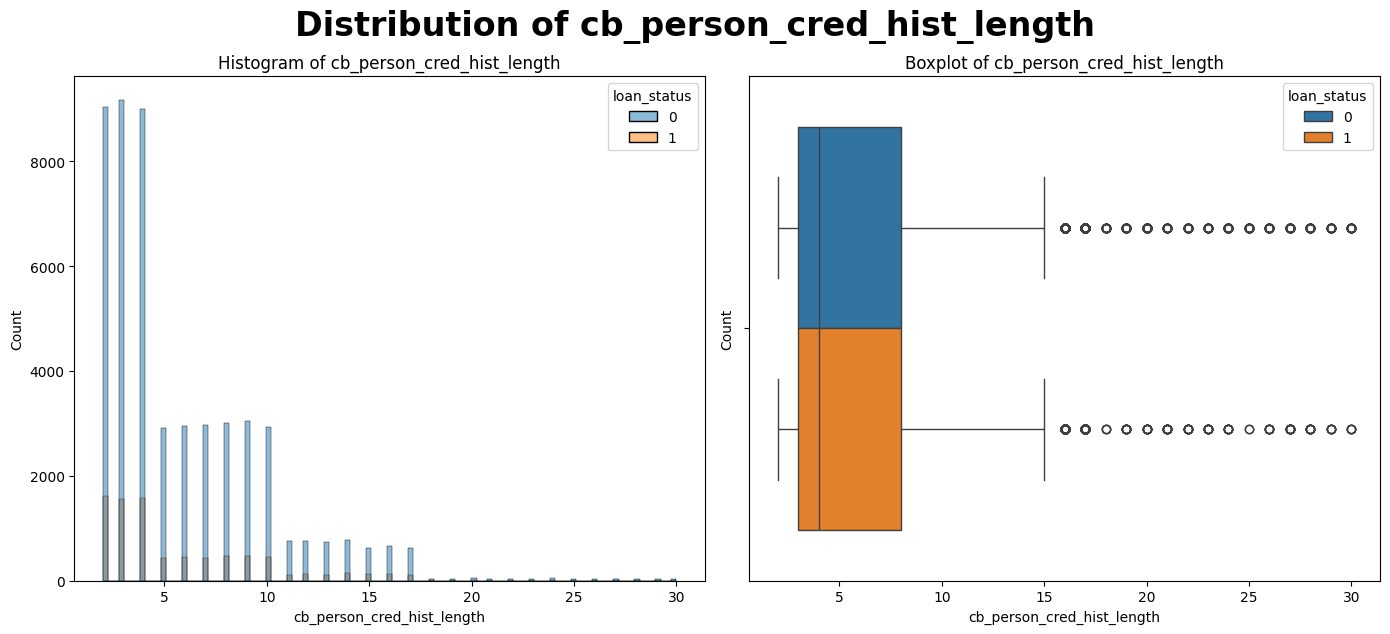

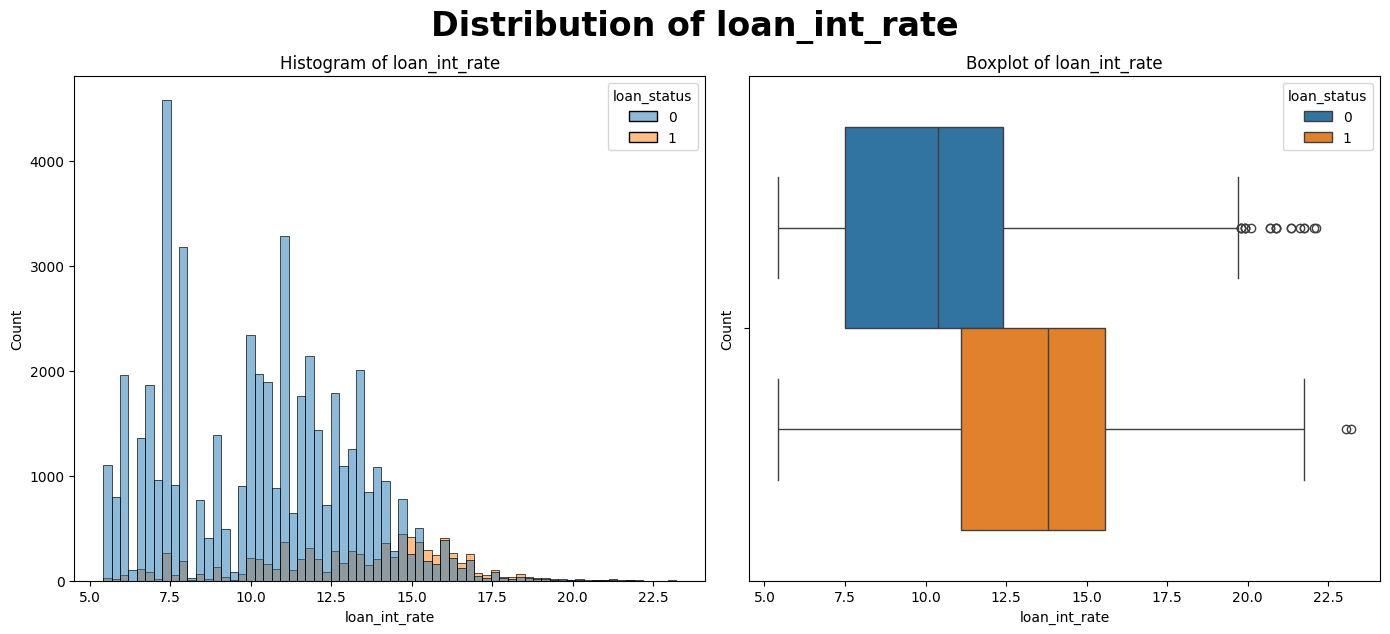

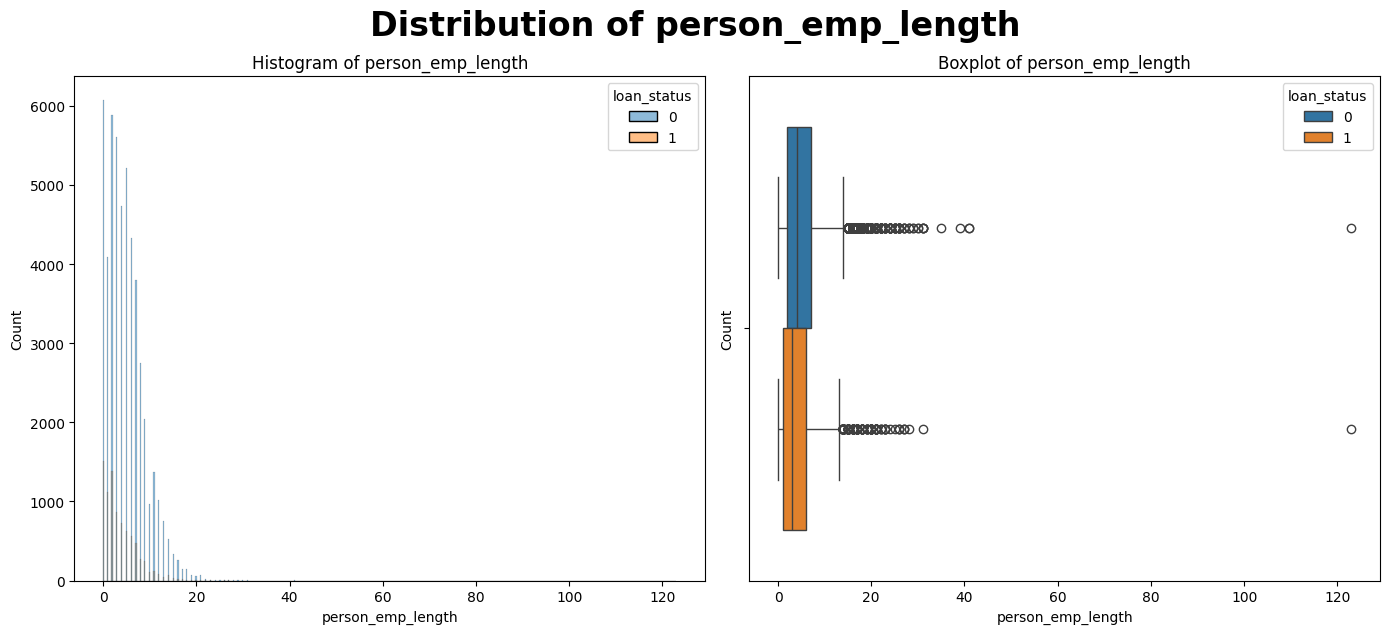

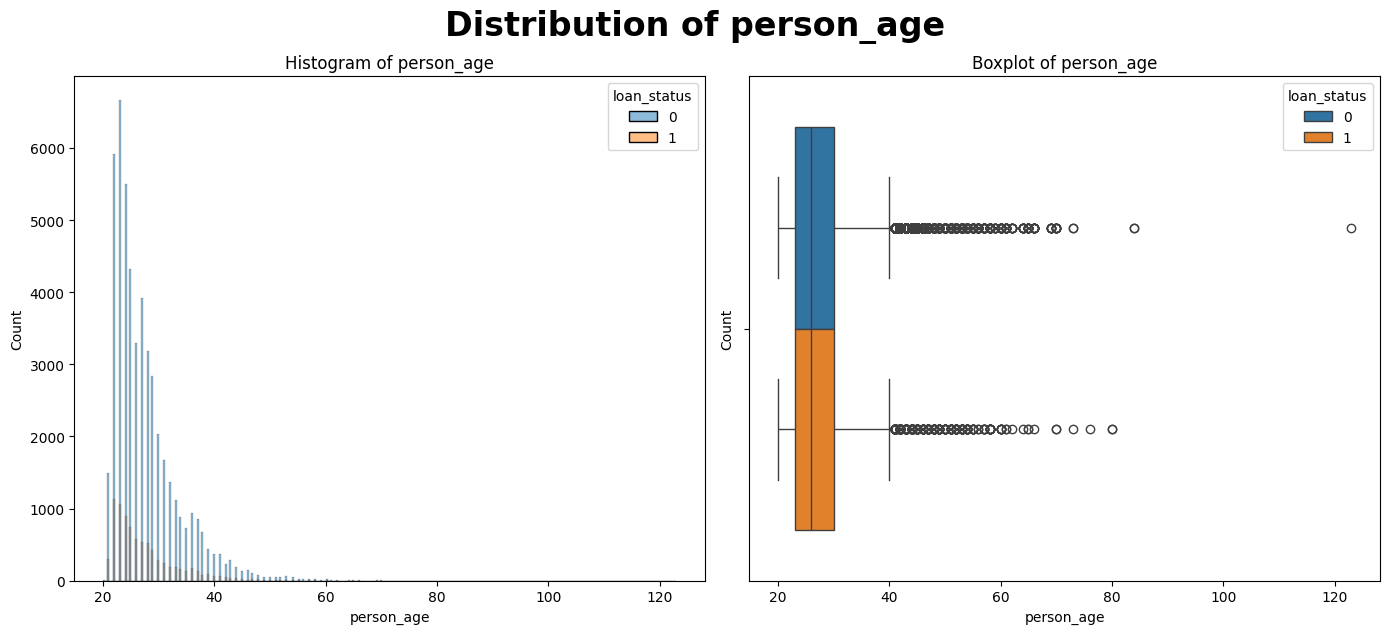

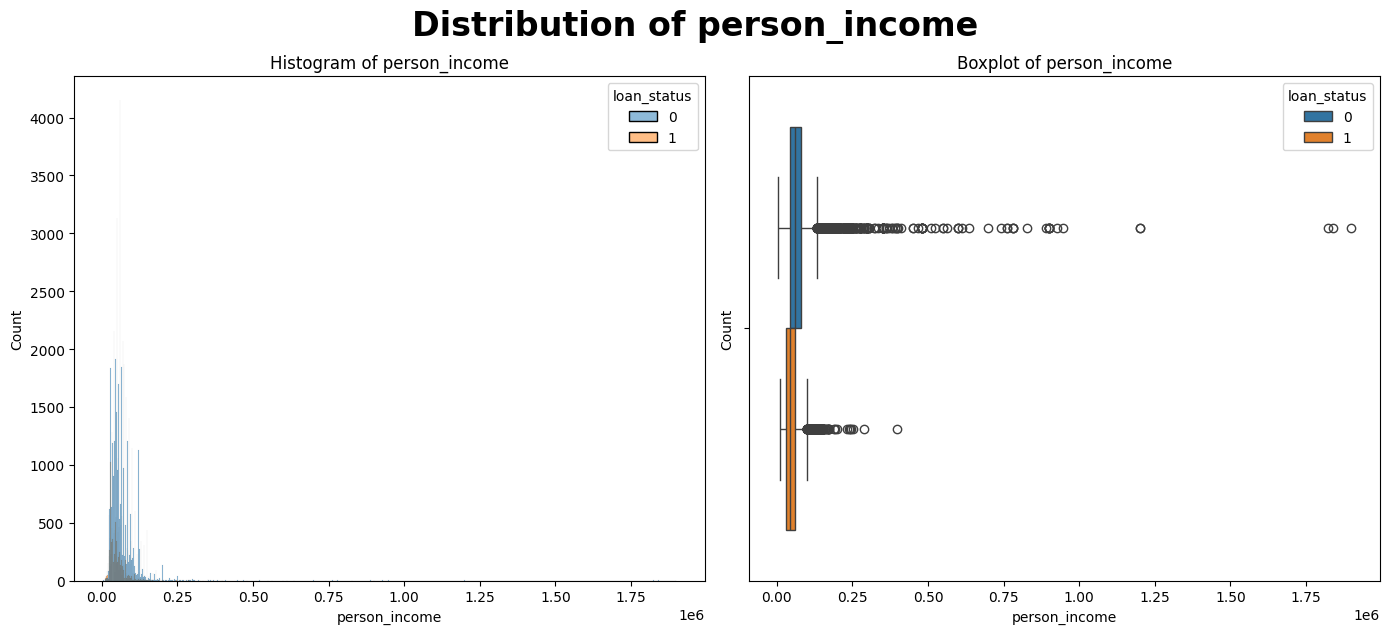

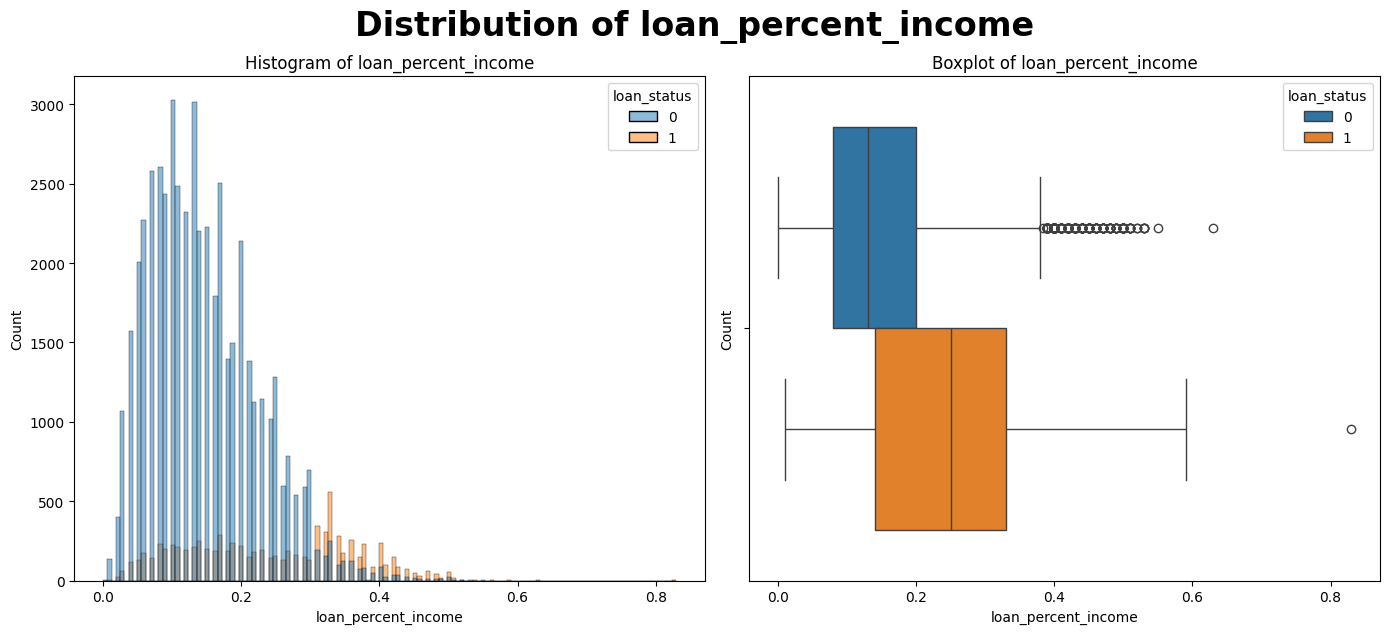

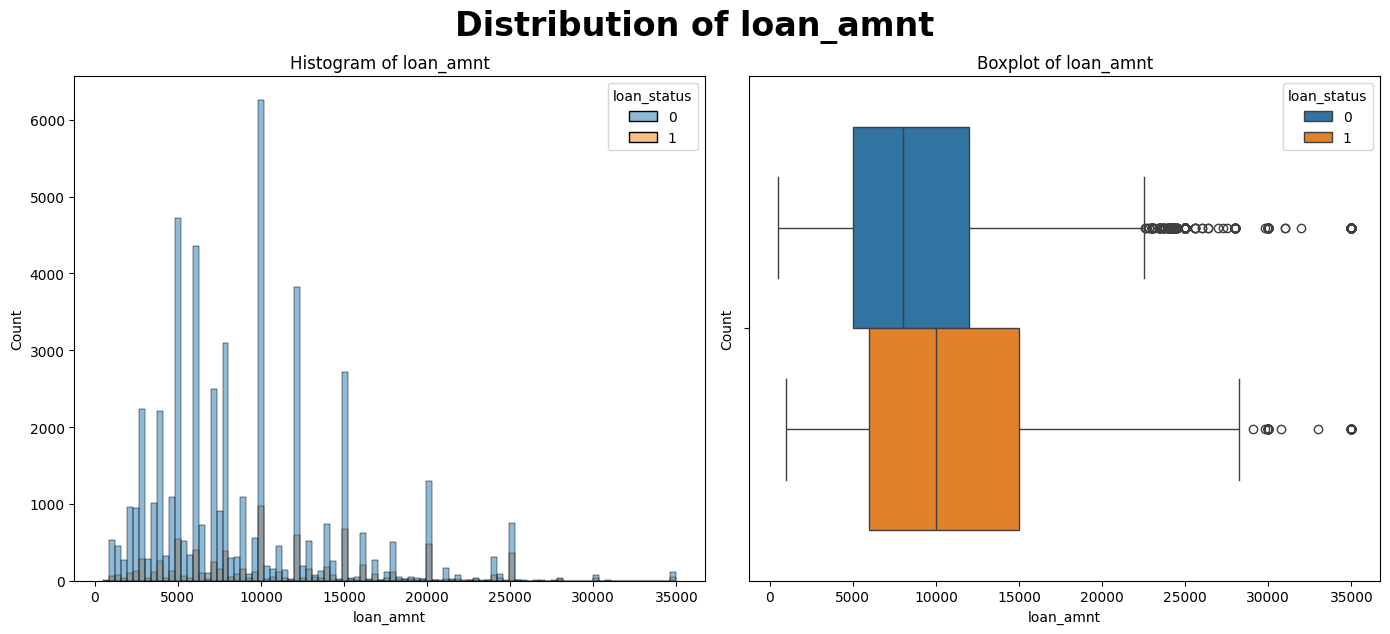

In [ ]:
for col in numerical_features:
    feature_distribution_plot(train_df, col, target)

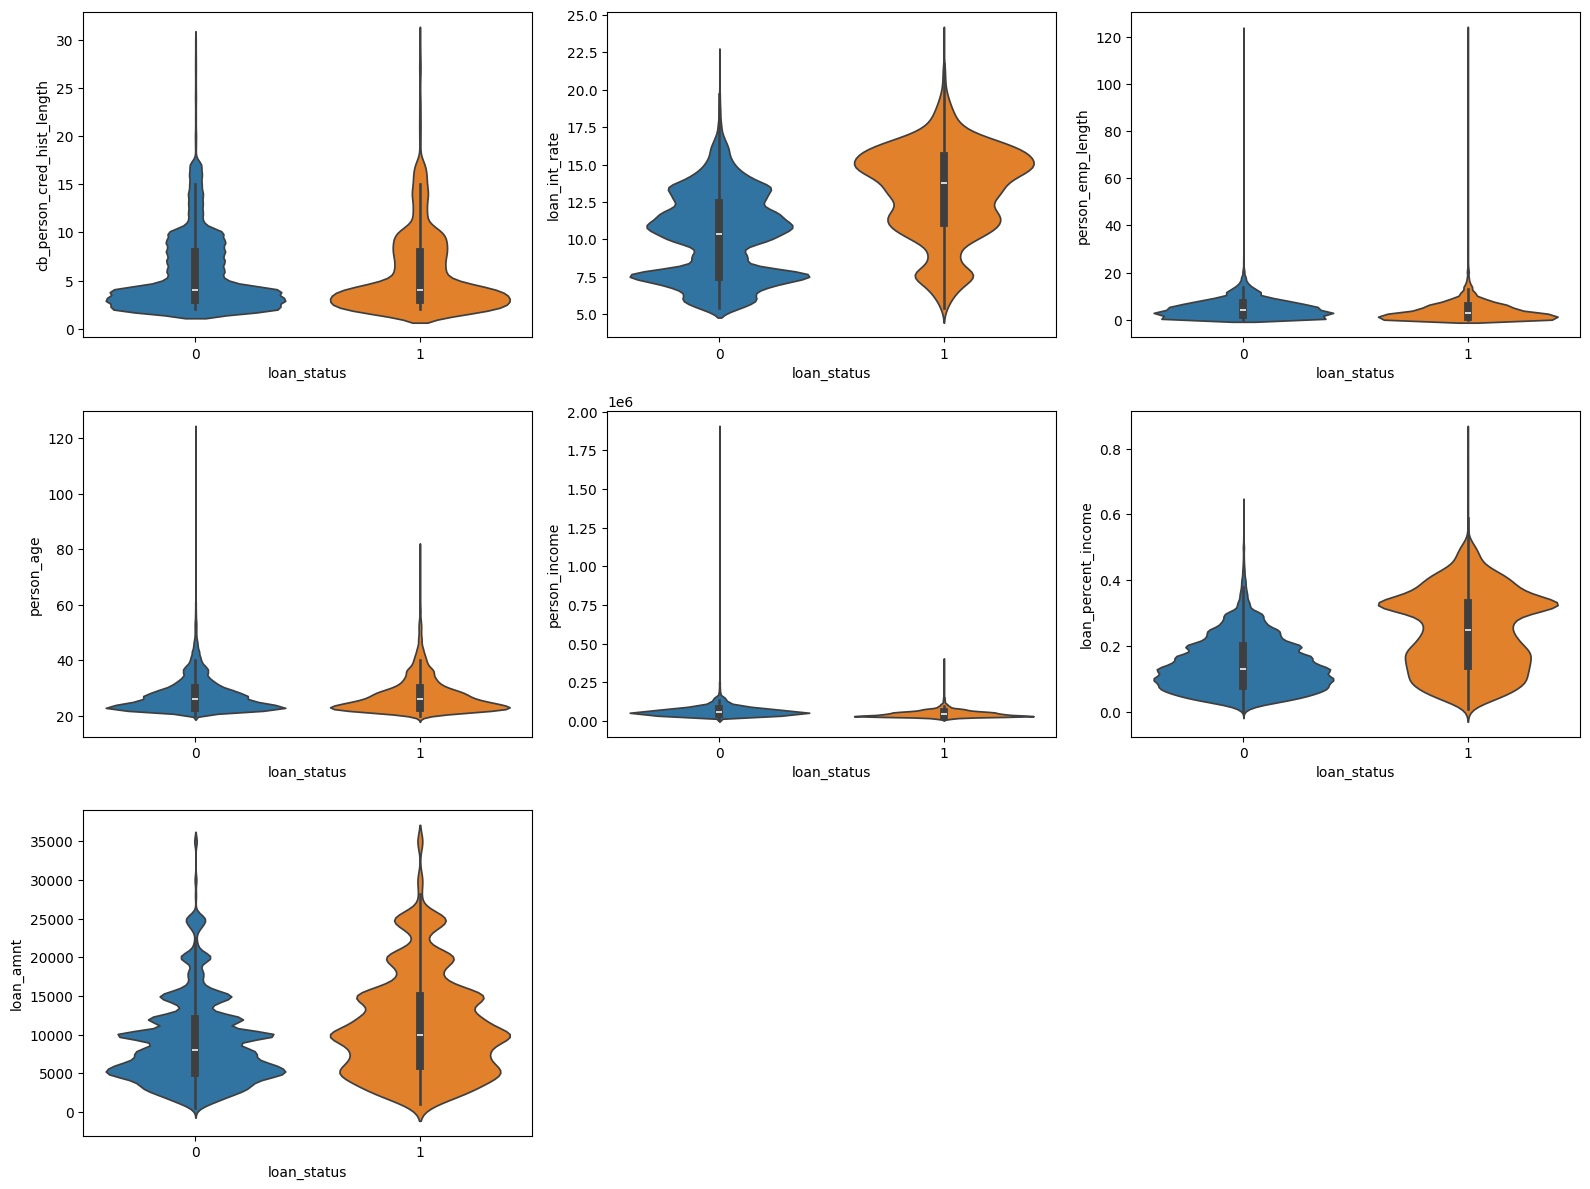

In [ ]:
plt.figure(figsize=(16, 12))

for i, col in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)
    sns.violinplot(train_df, x=target, y=col, hue=target, legend=None)

plt.tight_layout()
plt.show()

#### Distribution of Categorical Features

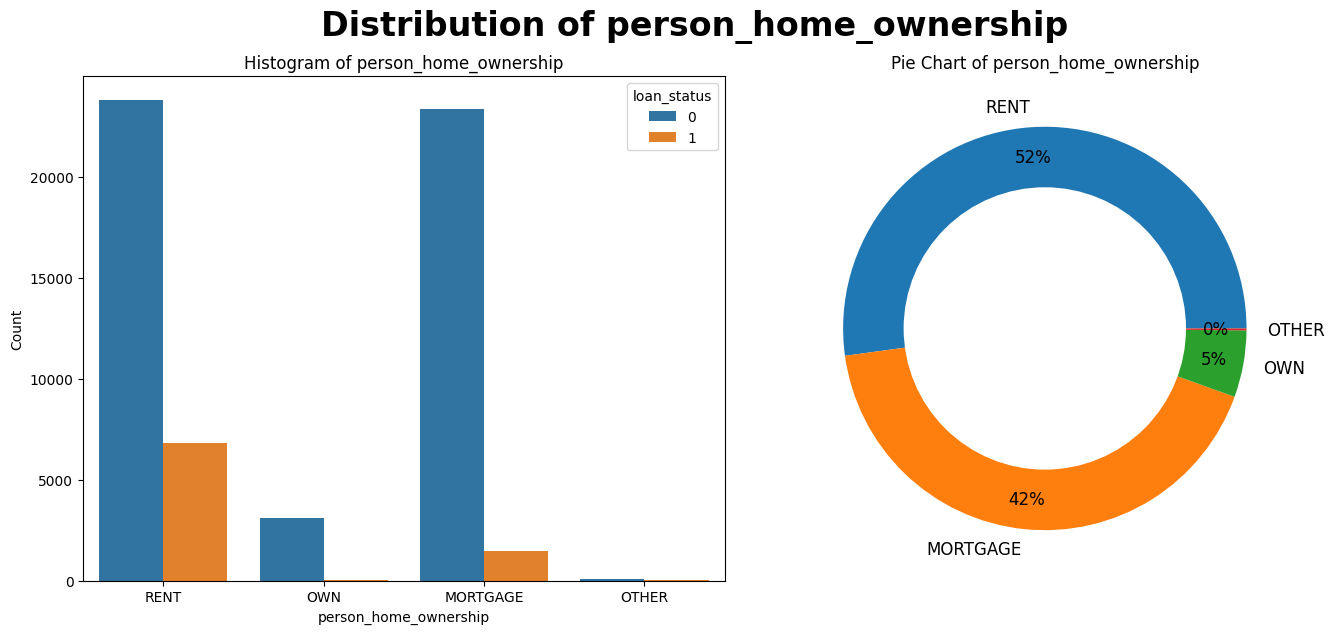

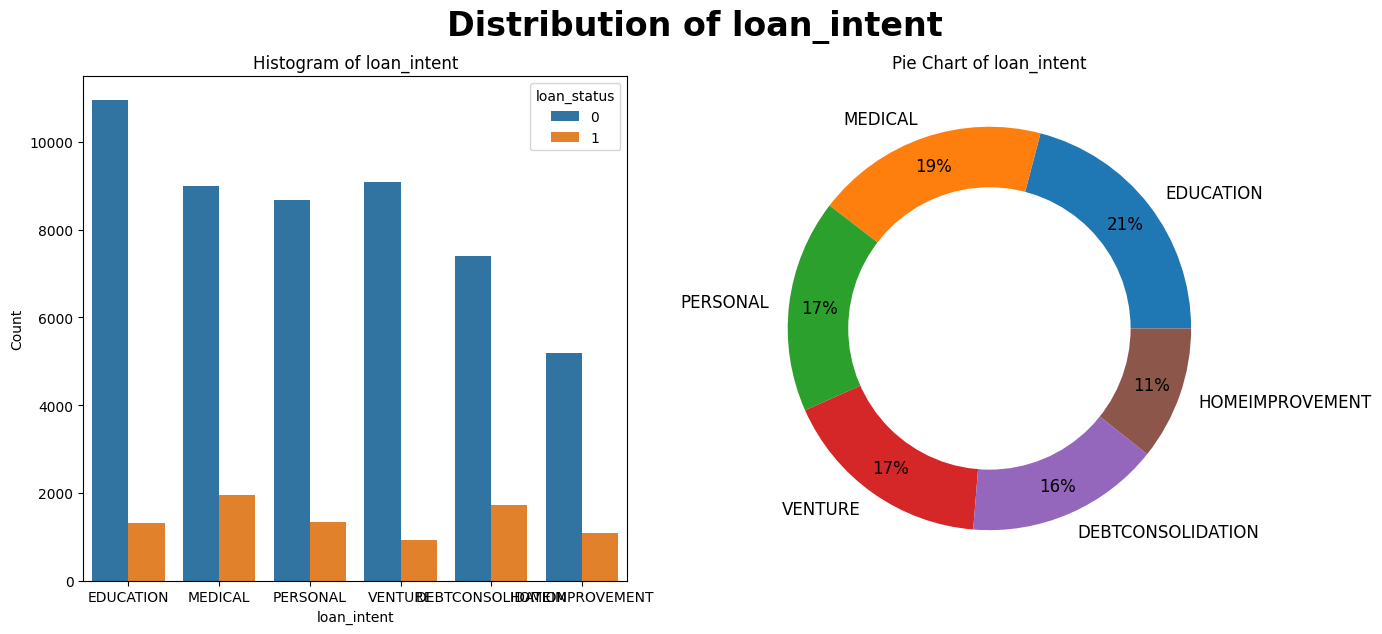

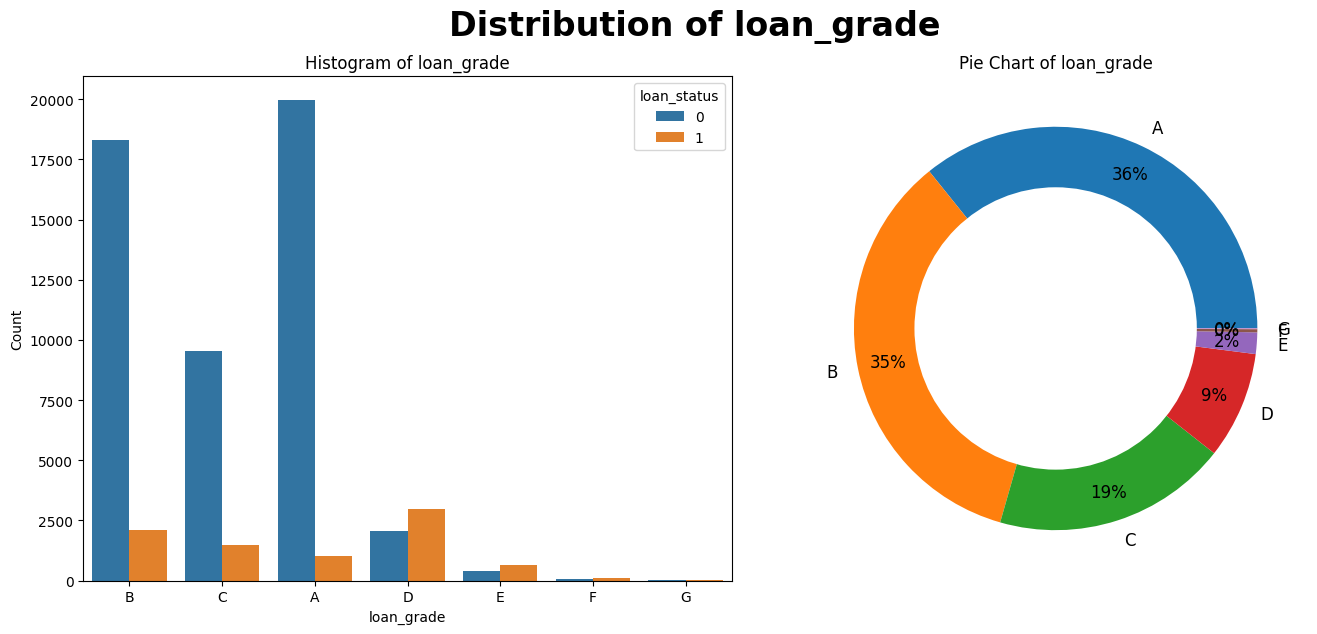

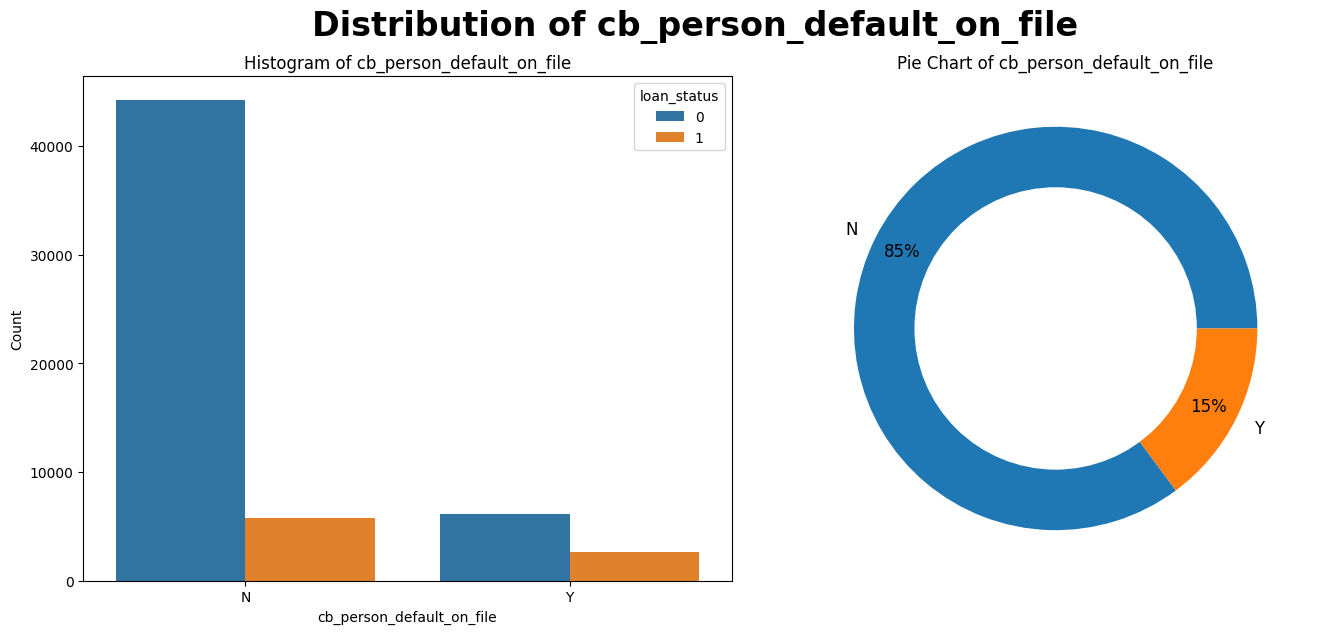

In [ ]:
for col in categorical_features:
    feature_distribution_plot(train_df, col, target)

#### Target Distribution

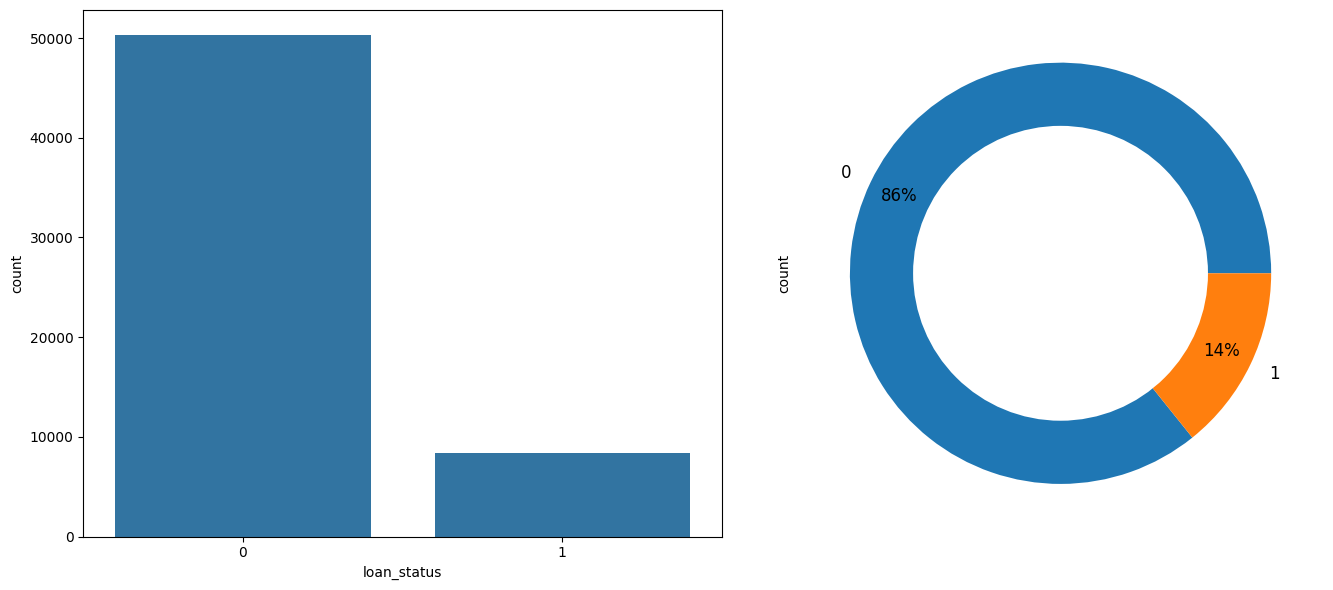

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.countplot(train_df, x=target)

plt.subplot(1,2,2)
train_df[target].value_counts().plot.pie(autopct='%.0f%%',pctdistance=0.85,fontsize=12)
plt.gca().add_artist(plt.Circle((0,0),radius=0.7,fc='white'))

plt.tight_layout()
plt.show()

#### Correlation Matrix

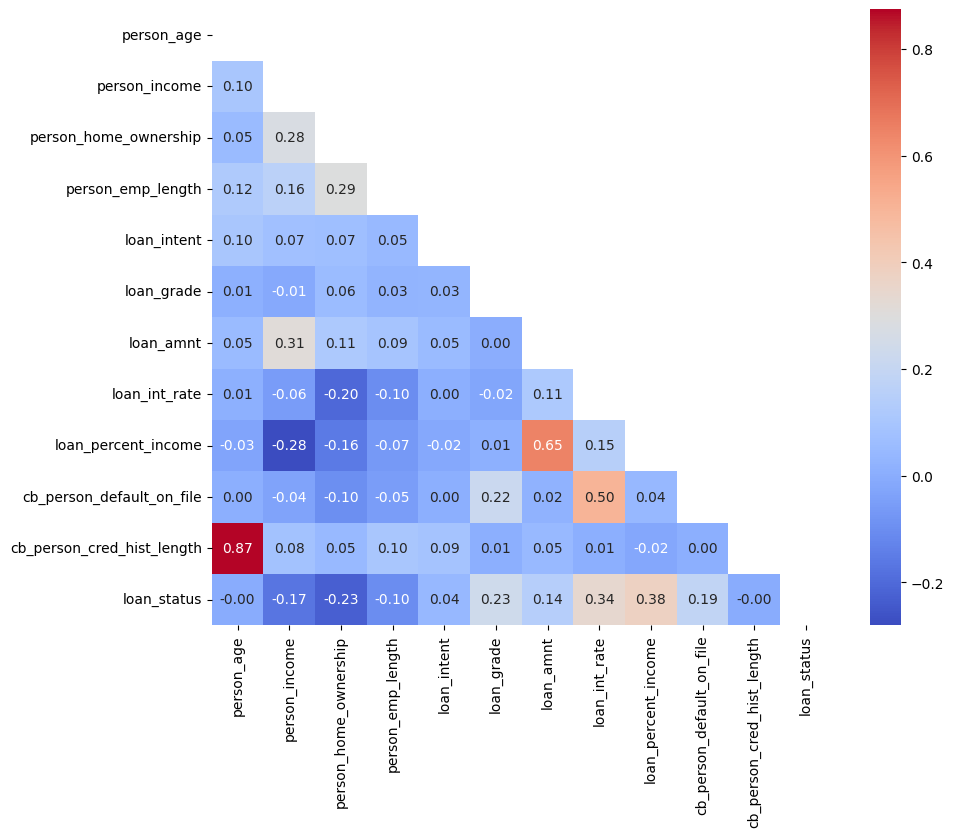

In [ ]:
train_new = train_df.copy()

for col in categorical_features:
    train_new[col], _ = train_new[col].factorize()

cor_mat = train_new.corr()
mask = np.triu(cor_mat)


plt.figure(figsize=(10, 8))
sns.heatmap(cor_mat, fmt='.2f', annot=True, mask=mask, cmap='coolwarm')
plt.show()

## 📏 Metric for Model Evaluation

In [ ]:
def convert_to_string(df):
    df_cat = df.copy()
    df_cat = df_cat.fillna(0)
    for col in features:
        df_cat[col] = df_cat[col].astype('string')
    return df_cat

In [ ]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
X = train_df.drop(target, axis=1)
y = train_df[target].ravel()

In [ ]:
oof_preds = []
oof_aucs = []
oof_train_preds = np.zeros(len(y))

cat_params={
    'task_type'           : "CPU",
    'loss_function'       : 'Logloss',
    'eval_metric'         : "AUC",
    'bagging_temperature' : 0.25,
    'colsample_bylevel'   : 0.40,
    'iterations'          : 5_000,
    'learning_rate'       : 0.045,
    'max_depth'           : 7,
    'l2_leaf_reg'         : 0.80,
    'min_data_in_leaf'    : 30,
    'random_strength'     : 0.25,
    'random_state'        : 42,
    'early_stopping_rounds': 200,
    'use_best_model'       : True,
    'allow_writing_files' : False,
} # parameters are taken from https://www.kaggle.com/code/martynovandrey/eda-and-lgb-cat-xgb

X_cat = convert_to_string(X)
test_cat = convert_to_string(test_df)
test_pool = Pool(test_cat, cat_features=features)

for fold, (train_idx, test_idx) in enumerate(skfold.split(X_cat, y)):
    X_train, y_train = X_cat.iloc[train_idx], y[train_idx]
    X_test, y_test = X_cat.iloc[test_idx], y[test_idx]

    X_train_pool = Pool(X_train, y_train, cat_features=features)
    X_test_pool = Pool(X_test, y_test, cat_features=features)

    cat_clf = CatBoostClassifier(**cat_params)
    cat_clf = cat_clf.fit(X=X_train_pool,
                          eval_set=X_test_pool,
                          verbose=500,
                          early_stopping_rounds=200)
    oof_train_preds[test_idx] = cat_clf.predict_proba(Pool(X_test, cat_features=features))[:, 1]
    test_pred = cat_clf.predict_proba(test_pool)[:, 1]

    oof_preds.append(test_pred)
    auc = roc_auc_score(y_test, oof_train_preds[test_idx])
    oof_aucs.append(auc)
    print(f"\nFold {fold+1}--> ROC-AUC Score: {auc:.6f}\n")

    del X_train, y_train, X_test, y_test
    del X_train_pool, X_test_pool
    del cat_clf
    gc.collect()

auc_mean = np.mean(oof_aucs)
auc_std = np.std(oof_aucs)
print(f"\nAverage Fold ROC-AUC Score: {auc_mean:.6f} \xB1 {auc_std:.6f}\n")


test_pred_cat = np.mean(oof_preds, axis=0)

Teknik **Stratified K-Fold Cross Validation** dan **CatBoost** yang digunakan dalam kode di atas dipilih untuk menangani masalah prediksi persetujuan pinjaman dengan target **AUC (Area Under Curve)** yang tinggi. Berikut adalah alasan mengapa teknik-teknik ini dipilih:

### 1. **Stratified K-Fold Cross Validation (StratifiedKFold)**
   - **Pembagian Stratifikasi:** Dalam kasus prediksi persetujuan pinjaman, target sering kali tidak seimbang (biasanya lebih banyak data ditolak atau diterima). Oleh karena itu, penggunaan **Stratified K-Fold** membagi data berdasarkan distribusi target, memastikan proporsi target dalam setiap fold sama. Hal ini membantu model agar tidak terlalu condong ke kelas mayoritas.
   - **Meminimalisir Overfitting**: Cross-validation (CV) yang terbagi menjadi 10 fold memungkinkan model dievaluasi secara lebih menyeluruh dan memitigasi risiko overfitting karena model diuji pada berbagai subset data.
   - **Memaksimalkan Generalisasi**: Teknik ini mengevaluasi model dengan lebih baik dibandingkan menggunakan satu kali train-test split, karena setiap data akan digunakan baik sebagai data latih maupun uji, sehingga meningkatkan generalisasi model.

### 2. **CatBoost untuk Model**
   - **Kemampuan Menangani Data Kategorikal Secara Efektif**: CatBoost (CatBoostClassifier) dirancang untuk menangani data kategorikal tanpa perlu preprocessing kompleks, sehingga kolom kategorikal dapat langsung digunakan dalam format string. Fungsi `convert_to_string` mengonversi fitur kategorikal untuk dimasukkan ke dalam CatBoost, yang lebih praktis dibanding encoding manual.
   - **Performansi pada Data dengan Banyak Fitur Kategorikal**: Pada kasus persetujuan pinjaman, data sering kali memiliki banyak fitur kategorikal (misalnya `person_home_ownership`, `loan_intent`, dll.). Model CatBoost yang dibangun dengan parameter ini akan secara efisien mengoptimalkan data tersebut.
   - **Regularisasi dan Pengaturan Parameter yang Baik**: Parameter seperti `l2_leaf_reg` dan `random_strength` diatur untuk mengurangi overfitting. Parameter `colsample_bylevel` yang dipilih membatasi jumlah fitur yang dipakai di setiap level, sementara `learning_rate` yang rendah memungkinkan pembelajaran bertahap.
   - **Early Stopping**: Penggunaan **early stopping** dengan `early_stopping_rounds` yang diatur ke 200 membantu menghentikan training jika model mulai overfit selama proses fitting, terutama dalam 5.000 iterasi.
   - **ROC-AUC sebagai Metric Utama**: AUC menjadi fokus karena memberikan metrik yang lebih stabil pada dataset imbalanced, terutama pada binary classification. Ini mengukur seberapa baik model dapat memisahkan kelas, yang relevan untuk klasifikasi persetujuan pinjaman, di mana kita ingin memaksimalkan pengenalan kelas yang tepat.

### 3. **Out-Of-Fold (OOF) Predictions**
   - **Menghindari Data Leakage**: OOF digunakan agar prediksi dari setiap fold tidak menggunakan data yang pernah dilihat model sebelumnya, sehingga setiap `fold` uji dapat dianggap sebagai data baru.
   - **Agregasi untuk Generalisasi pada Data Test**: Dengan menyimpan prediksi dari setiap fold, prediksi akhirnya diambil sebagai rata-rata `oof_preds`. Ini memberikan estimasi yang lebih stabil dan mengurangi kemungkinan hasil akhir bias karena fold tertentu.

### 4. **Penggunaan `roc_auc_score` dan Pengumpulan Statistik**
   - **Mengukur Variabilitas Model di Setiap Fold**: Dengan mencatat `roc_auc_score` untuk setiap fold (`oof_aucs`), kita mendapatkan gambaran rata-rata performa model (`auc_mean`) dan standar deviasi (`auc_std`). Ini memberikan insight apakah model stabil di setiap fold atau mengalami variabilitas, yang bisa menjadi indikator kualitas model.
   - **Evaluasi Robustness Model**: Menggunakan `roc_auc_score` sebagai evaluasi di setiap fold dapat menunjukkan seberapa baik model menangani data yang belum pernah dilihat, sehingga prediksi akhir di test set lebih terpercaya.

Secara keseluruhan, teknik ini sangat cocok untuk memaksimalkan akurasi dan ketahanan prediksi pada data yang mungkin memiliki distribusi target yang tidak seimbang, dan ini dapat memberikan hasil yang konsisten pada data uji yang sebenarnya.

# Submission

In [ ]:
sub = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/playground-series-s4e10/sample_submission.csv'

In [ ]:
ext1 = pd.read_csv("/kaggle/input/boosting-synergy-six-model-blend-for-loan-predict/submission.csv")[target].ravel()
ext2 = pd.read_csv("/kaggle/input/ps4e10-yunbase/ensemble.csv.csv")[target].ravel()
ext3 = pd.read_csv("/kaggle/input/ps-s4-e10-ensemble-of-solutions/submission.csv")[target].ravel()

In [ ]:
res = np.average([ext1, ext2, ext3, test_pred_cat], weights=[20, 6, 8, 1], axis=0)

In [ ]:
sub[target] = res
sub.to_csv('submission.csv', index=False)